# Descriptor space analysis
This notebook demonstrates how to visualize the descriptor space for a collection of structures using principal component Analysis (PCA) as implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

All models and structures required for running this and the other tutorial notebooks can be obtained from [Zenodo](https://zenodo.org/record/10658778).
The files are also available in the `tutorials/` folder in the [GitLab repository](https://gitlab.com/materials-modeling/calorine/-/tree/master/tutorials).

## Setup example system and calculate descriptors

We start by generating a few rattled structures and energy-volume (EV) curves for `PbTe`.
Note that the unit cell for the EV structures is repeated.
This is done in order to demonstrate that not all structures in a dataset need to have the same number of atoms. 

The descriptors for each strucutre are calculated using the `calorine.nep.get_descriptors()` function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from sklearn.decomposition import PCA

from calorine.nep import get_descriptors

In [2]:
descriptors = []
model_filename = 'nep-PbTe.txt'

# Generate a few different rattled structures
for k in range(50):
    structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
    structure.rattle(stdev=0.2, seed=k)
    descriptors.append(get_descriptors(structure, model_filename))
    
# Generate a few larger structures with (rattled) energy-volume curves as well
for k in range(3):
    for volscale in np.arange(0.7, 0.85, 0.01):
        structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7).repeat(2)
        latscale = volscale ** (1 / 3)
        structure.set_cell(structure.cell * latscale, scale_atoms=True)
        structure.rattle(stdev=0.2, seed=k)
        descriptors.append(get_descriptors(structure, model_filename))

## Performing PCA on the descriptors

We can now perform the PCA.
Note that the descriptors must be concatenated into a matrix with shape `(total number of atoms in dataset, descriptors components)`. 

**Tip:**
Do not forget to check the `pca.explained_variance_ratio_` property after the fit, to check if the PCA components represent the original high-dimensional descriptor space well. 

In [3]:
# Concatenate all descriptors
all_descriptors = np.concatenate(descriptors, axis=0)
print(f'Total number of atoms in dataset: {all_descriptors.shape[0]}')
print(f'Number of descriptor components:  {all_descriptors.shape[1]}')

# Perform PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(all_descriptors)

p0 = pca.explained_variance_ratio_[0]
p1 = pca.explained_variance_ratio_[1]
print(f'Explained variance for component 0: {p0:.2f}')
print(f'Explained variance for component 1: {p1:.2f}')

Total number of atoms in dataset: 868
Number of descriptor components:  30
Explained variance for component 0: 0.99
Explained variance for component 1: 0.01


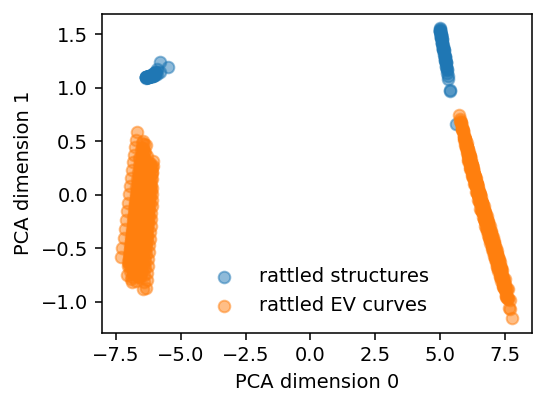

In [4]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=140)

ax.scatter(pc[:100, 0], pc[:100, 1], alpha=0.5, label='rattled structures')
ax.scatter(pc[100:, 0], pc[100:, 1], alpha=0.5, label='rattled EV curves')
ax.set_xlabel('PCA dimension 0')
ax.set_ylabel('PCA dimension 1')
ax.legend(frameon=False)

plt.tight_layout()

## Normalized vs non-normalized descriptors

Clusters in descriptor space are often more clearly separable if the descriptors are normalized beforehand.
Note that the normalization is taken over each atom, rather than over structures.
This is done in order to allow for the structures to differ in the number of atoms.

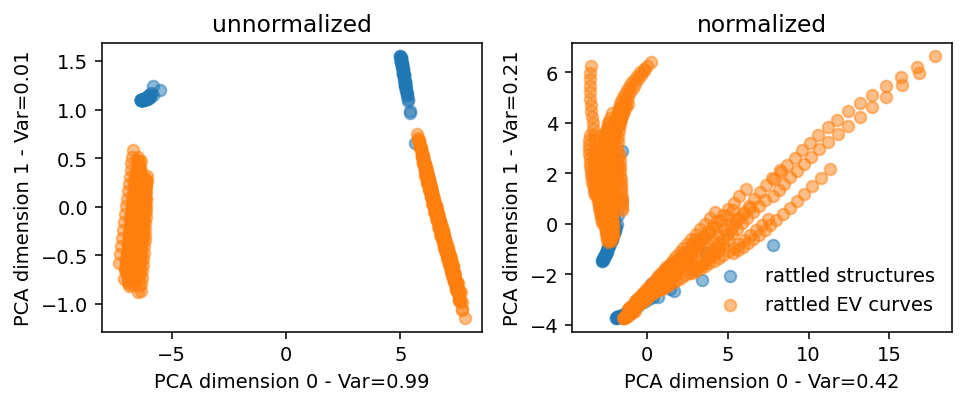

In [5]:
descriptor_mean = all_descriptors.mean(axis=0)
descriptor_std = all_descriptors.std(axis=0)
normalized_descriptors = [(d - descriptor_mean) / descriptor_std for d in descriptors]

fig, axes = plt.subplots(ncols=2, figsize=(7, 3), dpi=140)

for k, ax in enumerate(axes):
    pca = PCA(n_components=2)
    if k == 0:
        pc = pca.fit_transform(all_descriptors)
        title = 'unnormalized'
    else:
        pc = pca.fit_transform(np.concatenate(normalized_descriptors, axis=0))
        title = 'normalized'
    ax.scatter(pc[:100, 0], pc[:100, 1], alpha=0.5, label='rattled structures')
    ax.scatter(pc[100:, 0], pc[100:, 1], alpha=0.5, label='rattled EV curves')
    ax.set_xlabel(f'PCA dimension 0 - Var={pca.explained_variance_ratio_[0]:.2f}')
    ax.set_ylabel(f'PCA dimension 1 - Var={pca.explained_variance_ratio_[1]:.2f}')
    ax.set_title(title)
ax.legend(frameon=False)

plt.tight_layout()
fig.align_ylabels()